In [1]:
%matplotlib inline
from skimage import data, segmentation, io
from skimage import filters
from skimage.measure import profile_line
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
def intensity_profile(image, start, end, num_points):
    """
    Calculate the intensity profile along a line segment in an image.

    Parameters:
        image : The input image (grayscale).
        start (tuple): The starting point of the line segment (x, y).
        end (tuple): The ending point of the line segment (x, y).
        num_points (int): The number of equally spaced points to sample along the line segment.

    Returns:
        numpy.ndarray: The intensity profile along the line segment, normalized between 0 and 1.
    """

    # convert image numpy array
    image_data = np.array(image)
    nrows, ncols = image_data.shape[0], image_data.shape[1]

    # check if start and end points are within image
    if start[0] < 0 or start[0] > ncols or start[1] < 0 or start[1] > nrows:
        raise ValueError('start point is not within image')
    if end[0] < 0 or end[0] > ncols or end[1] < 0 or end[1] > nrows:
        raise ValueError('end point is not within image')

    # calculate slope and y-intercept
    slope = (end[1] - start[1]) / (end[0] - start[0])
    y_intercept = start[1] - slope * start[0]
    def line(x):
        return slope * x + y_intercept

    # calculate num_points equally spaced integer (x,y) coordinates along the line
    x = np.linspace(start[0], end[0], num_points, dtype=int)
    y = np.round(line(x)).astype(int)

    # read out image values at the coordinates
    values = image_data[y, x]

    # get intensity values between 0 and 1
    min_value, max_value = values.min(), values.max()
    diff = max_value - min_value
    intensity = (values - min_value) / diff
    # Define window size for moving average
    window_size = 2

    # Create a uniform window
    window = np.ones(window_size) / window_size

    # Apply moving average to intensity
    smooth_intensity = np.convolve(intensity, window, mode='same')
    return smooth_intensity
    
    

In [3]:
def createLineIterator(img, P1, P2):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = float(dX)/float(dY)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = np.array(slope*(itbuffer[:,1]-P1Y), dtype=int)+ P1X
        else:
            slope = float(dY)/float(dX)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = np.array(slope*(itbuffer[:,0]-P1X), dtype=int)+ P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[np.array(itbuffer[:,1], dtype=int),np.array(itbuffer[:,0], dtype=int)]
    return itbuffer

In [10]:
import numpy as np
from scipy.ndimage import map_coordinates

def improfile(img, xi, yi, N):
    # Create coordinate arrays
    x = np.linspace(xi[0], xi[1], N)
    y = np.linspace(yi[0], yi[1], N)
    coords = np.vstack((y,x)) # stack them as a (2, N) array

    # Extract the intensities along the line
    intensities = map_coordinates(img, coords, order=1,  mode='nearest')

    return intensities


Segmentation contours
=====================

Visualize segmentation contours on original grayscale image.



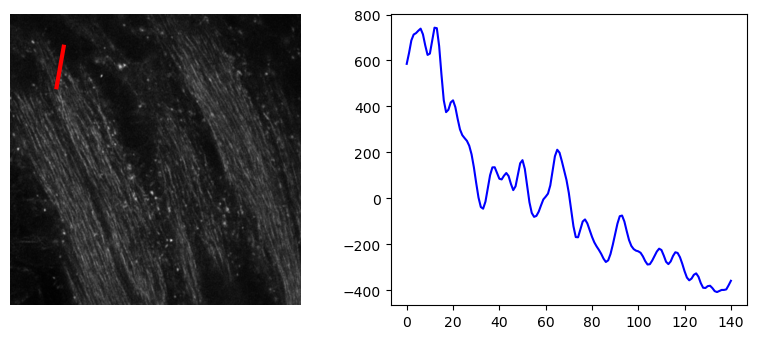

In [11]:

import pandas as pd
coins = data.coins()
mask = coins > filters.threshold_otsu(coins)
clean_border = segmentation.clear_border(mask).astype(int)
#io.imsave('comparison/clean_border.png', clean_border)


coins = pd.read_csv('comparison/raw.csv', header=None).to_numpy()

start, end = [157.9966, 182.3073],[247.2001,109.3270]
test = improfile(coins,start, end, 2*70+1)
test = test-np.mean(test)


plt.figure(figsize=(8, 3.5))
plt.subplot(121)
plt.imshow(coins, cmap='gray')
plt.plot(start,end , '-r', linewidth=3)  # Plot a red line across the middle

plt.axis('off')
plt.subplot(122)
plt.plot(test, '-b')

plt.tight_layout()
plt.show()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])